## Corpus

In [1]:
from corpus import download_and_unzip, catgeories, corpus_root, read_text_files

In [2]:
download_and_unzip()

Already downloaded and extracted!


In [3]:
import os
from tqdm import tqdm


reviews = []
labels = []

# we can't use the previous tokenizers here
# idx 0 -> neg, 1 -> pos
# one hot labels
for idx, cat in enumerate(catgeories):
    path = os.path.join(corpus_root, cat)
    texts = read_text_files(path)

    for i in tqdm(range(len(texts)), desc="prepare_corpus"):
        text = texts[i]
        reviews.append(text)
        
        one_hot = [0, 0]
        one_hot[idx] = 1
        
        labels.append(one_hot)

prepare_corpus: 100%|██████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1976580.58it/s]


In [4]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    reviews, labels, random_state=42, train_size=0.8
)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=42)

## Dataloader


In [5]:
import numpy as np
import jax
from jax import numpy as jnp

In [6]:
from transformers import AutoTokenizer


model_name = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name) 

In [7]:
import torch
from torch.utils.data import Dataset

# custom dataset
class PolarityReviewDataset(Dataset):

    def __init__(self, reviews, labels, tokenizer):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.MAX_LEN = 128

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        label = self.labels[idx]

        # encode review text
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.MAX_LEN,
            truncation=True,
            return_token_type_ids=False,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="np"
        )
        

        return {
            "inputs": encoding,
            "label": np.array(label)
        }

In [8]:
training_dataset = PolarityReviewDataset(x_train, y_train, tokenizer)
val_dataset = PolarityReviewDataset(x_val, y_val, tokenizer)

In [9]:
for td in training_dataset:
    print(td)
    break

{'inputs': {'input_ids': array([[  101, 15349,  1159,   131,   178,  1138,  1309,   117,  1518,
         1562,  2065,  1114,  1103,  3223,   119,   178,  1274,   112,
          189,  1221,  1725,   117,  1541,   119,  3983,   112,   189,
         1458,  1106,  4031,  1122,  1149,  1113,  1888,   117,  3983,
          112,   189,  1151,  1120,  1313,  1103,  6823,  1122,  1108,
         1113,  2443,   189,  1964,   117,  1105,  1122,  1108,  1315,
         1677,  1106,  2797,  1103,  1314,  1159,  1122,  1108,  1113,
         1103,  1992,   118,  3251,   119,  1177,  1268,  1146,  1524,
          117,   178,   112,  1325,  5890,  1115,   178,  1274,   112,
          189,  1221,  1184,  1103, 26913,   178,   112,   182,  2520,
         1164,   117,  1133,  1303,  2947,   119,   119,   119,  1110,
          189,  5168,  7770,  1103,  2065,  1114,  1103,  3223,  1104,
         1103,  1997,   112,   188,   136,  2654,  1115,   112,   188,
         1280,   170,  1376,  2113,  1315,  1677,   

In [10]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)
    
    
# collate fn
# https://github.com/google/jax/issues/3382
def collate_fn(batch):
    if isinstance(batch[0], jnp.ndarray):
        return jnp.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        return type(batch[0])(collate_fn(samples) for samples in zip(*batch))
    else:
        return jnp.asarray(batch)

In [11]:
from torch.utils.data import DataLoader

batch_size = 16

# loader from custom dataset
train_loader = DataLoader(training_dataset, shuffle=True, batch_size=batch_size, 
                          pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size, 
                        pin_memory=True)

In [12]:
for td in train_loader:
    print(td)
    break

{'inputs': {'input_ids': tensor([[[  101,  1505,  1122,  ...,  1132,  1549,   102]],

        [[  101, 21718,  1306,  ...,  1106,  2824,   102]],

        [[  101,  1148, 25263,  ...,  1178,  1225,   102]],

        ...,

        [[  101,  1106,  1306,  ...,  1104,  1103,   102]],

        [[  101,  1451,  1517,  ...,   188, 12283,   102]],

        [[  101,  1107,  1139,  ...,  3768,  1118,   102]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1]],

        ...,

        [[1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1]]])}, 'label': tensor([[0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]])}


## Model

In [13]:
import flax
from flax import linen as nn

from transformers import FlaxBertModel

# define the model

class SentiBert(nn.Module):
    @nn.compact  
    def __call__(self, x):
        bert = FlaxBertModel.from_pretrained(model_name)
        out = bert(**x)
        out = out.pooler_output
        linear = nn.Dense(features=2)
        out = linear(out)
        
        return out

In [14]:
masterkey = jax.random.PRNGKey(42)
model_key, data_key = jax.random.split(masterkey)

In [15]:
model = SentiBert()


# dummy input
dummy = tokenizer.encode_plus("this is some text", max_length=128, padding="max_length", 
                              truncation=True, return_tensors="jax")

params = model.init(model_key, dummy)

Some weights of FlaxBertModel were not initialized from the model checkpoint at bert-base-cased and are newly initialized: {('pooler', 'dense', 'kernel'), ('pooler', 'dense', 'bias')}
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
dummy

{'input_ids': DeviceArray([[ 101, 1142, 1110, 1199, 3087,  102,    0,    0,    0,    0,
                 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                 0,    0,    0,    0,    0,    0,    0,    0]],            dtype=int32), 'token_ty

In [17]:
model.apply(params, dummy)

Some weights of FlaxBertModel were not initialized from the model checkpoint at bert-base-cased and are newly initialized: {('pooler', 'dense', 'kernel'), ('pooler', 'dense', 'bias')}
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DeviceArray([[-0.13187033,  0.21753377]], dtype=float32)

In [18]:
jax.tree_map(lambda x:x.shape, params)

FrozenDict({
    params: {
        Dense_0: {
            bias: (2,),
            kernel: (768, 2),
        },
    },
})

In [19]:
@jax.jit
def cross_entropy(logits, labels):
    return -jnp.sum(labels * jax.nn.log_softmax(logits, axis=-1), axis=-1)

In [20]:
def loss_fn(params, inputs, labels):
    logits = model.apply(params, inputs)
    loss = cross_entropy(logits, labels).mean()
    return loss

In [21]:
qq = np.random.rand(16, 2)
ll = np.array([[0, 1]] * 16)
cross_entropy(qq, ll)

DeviceArray([0.73427236, 0.59097636, 0.6020518 , 1.0221114 , 0.60700476,
             0.55114216, 0.63427025, 0.78005785, 0.9379386 , 0.58483785,
             0.44559944, 0.73226553, 1.0747612 , 0.7124811 , 0.53850824,
             0.60080826], dtype=float32)

In [22]:
import optax

optimizer = optax.adam(learning_rate=2e-5)
optimizer_state = optimizer.init(params)
loss_fn_grad = jax.value_and_grad(loss_fn) 

In [23]:
@jax.jit
def train_step(params, opt_state, inputs, labels):
    loss, grads = loss_fn_grad(params, inputs, labels)
    updates, opt_state = optimizer.update(grads, opt_state)
    updated_params = optax.apply_updates(params, updates)
    
    return updated_params, opt_state, loss

In [28]:
epochs = 5

losses = list()

for e in range(epochs):
    for batch in tqdm(train_loader):
        inputs = batch["inputs"]
        
        print(inputs)
        break
        
        labels = batch["label"]
        
        params, optimizer_state, loss = train_step(params, optimizer_state, inputs, labels)
        losses.append(loss)
    break

  0%|                                                                                                | 0/80 [00:00<?, ?it/s]

{'input_ids': tensor([[[  101,  1122,   112,  ...,   188,  6617,   102]],

        [[  101,  1165,  6103,  ...,   170, 10310,   102]],

        [[  101,   188,  5730,  ...,  4763,   119,   102]],

        ...,

        [[  101,  2851,  8755,  ...,  1104,  1103,   102]],

        [[  101, 12477,  5997,  ...,  1103,  1322,   102]],

        [[  101,  1155,  1268,  ...,  4055,  2008,   102]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1]],

        ...,

        [[1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1]]])}


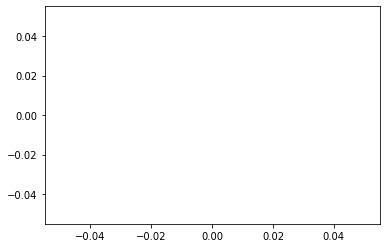

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot([i for i in range(len(losses))], losses)

# Look into collate_fn for pytorch dataloaders